# GDAL vs SAGA Computation

This notebook compares the different computational speeds of a couple terrain parameters using GDAL and SAGA libraries.

Only the parameters for slope and aspect should be computed as those are the two shared parameters both libraries compute (based on utilized algorithm).

## Preconfiguration

Import the needed libraries to run the code blocks.

In [1]:
from osgeo import gdal
import crop_functions as cp
import compute_functions as cm
import geotiled
import glob
import time
import os

Modify the testing parameters below to change the data computed and set different tiles sizes for testing.

Do not specify tile sizes that would cause the final file count to exceed the number of cores available for the best performance results.

In [2]:
# The working directory to store files in
working_directory = '/media/volume/geotiled-saga/gdal_saga_test'
geotiled.set_working_directory(working_directory)

# Size of tiles to produce specified as a list of [x,y] values (units of pixels)
tile_sizes = [[18274,16862],[18274,8431],[9137,8431],[9137,4216],[4569,4216]]

# Data to download
resolution = '30m'
region = 'TN'

# Data to compute
parameters = ['slope','aspect']

# Number of runs to do
runs = 10

Create CSV file to store results to.

In [5]:
file = open('results.csv', 'w')
file.write('method,parameter,tile_size,run_number,compute_time,overhead_time\n')
file.close()

## Initialization

Download, preprocess, and crop the data.

In [ ]:
# Download the desired data
geotiled.fetch_dems(shapefile=region, dataset=resolution, save_to_txt=False, download=True)

# Mosaic DEMs
geotiled.mosaic_rasters(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation')

# Reproject mosaic into computable format
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918')

# Crop elevation data into specified tile sizes
for ts in tile_sizes:
    cp.parallel_crop('elevation.tif', f"{ts[0]}x{ts[1]}_tiles", ts[0], ts[1])



ownloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [00:17<00:00, 99.6MB/s]

In [3]:
# Get size information about elevation file
elevation_file = gdal.Open('elevation.tif')
elev_width = elevation_file.RasterXSize
elev_height = elevation_file.RasterYSize

## Compute with GDAL

Compute the parameters using GDAL and record the time it takes to execute.

In [8]:
# Whole image run
input_file = os.path.join(os.getcwd(), 'elevation.tif')
for param in parameters:
    for i in range(runs):
        # Set output path
        output_file = os.path.join(os.getcwd(), f"gdal_{param}.tif")
    
        # Compute
        start_time = time.time()
        dem_options = gdal.DEMProcessingOptions(format='GTiff', creationOptions=['COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=YES'])
        if param == 'aspect':
            dem_options = gdal.DEMProcessingOptions(zeroForFlat=False, format='GTiff', creationOptions=['COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=YES'])
        gdal.DEMProcessing(output_file, input_file, processing=param, options=dem_options)
        compute_time = time.time() - start_time

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"GDAL,{param},{elev_width}x{elev_height},{i},{compute_time},0\n")
        file.close()

In [12]:
for param in parameters:
    for ts in tile_sizes:
        # Get all input files
        input_files = glob.glob(os.path.join(os.getcwd(), f"{ts[0]}x{ts[1]}_tiles", "tile_*.tif"))
        
        for i in range(runs):
            for input_file in input_files:
                # Set output path
                output_file = os.path.join(os.path.dirname(input_file), f"gdal_{param}_{os.path.basename(input_file)}")
            
                # Compute
                start_time = time.time()
                dem_options = gdal.DEMProcessingOptions(format='GTiff', creationOptions=['COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=YES'])
                if param == 'aspect':
                    dem_options = gdal.DEMProcessingOptions(zeroForFlat=False, format='GTiff', creationOptions=['COMPRESS=LZW', 'TILED=YES', 'BIGTIFF=YES'])
                gdal.DEMProcessing(output_file, input_file, processing=param, options=dem_options)
                compute_time = time.time() - start_time
    
                # Update CSV
                file = open('results.csv', 'a')
                file.write(f"GDAL,{param},{ts[0]}x{ts[1]},{i},{compute_time},0\n")
                file.close()

## Compute with SAGA

Compute the parameters using SAGA and record the time it takes to execute. Note that overhead of converting files from GeoTIFF to SGRD and back are included as a separate time.

In [4]:
# Whole image run
input_file = os.path.join(os.getcwd(), 'elevation.tif')
for param in parameters:
    for i in range(runs):
        # Set output path
        output_file = os.path.join(os.getcwd(), f"saga_{param}.tif")
    
        # Convert input file to SGRD
        start_time = time.time()
        geotiled.convert_file_format(input_file, input_file.replace('.tif','.sdat'), 'SAGA')
        overhead_time = time.time() - start_time
        
        # Compute
        start_time = time.time()
        cmd = ["saga_cmd", "-c=1", "ta_morphometry", "0", "-ELEVATION", input_file.replace('.tif','.sgrd')]
        if param == 'slope':
            cmd = cmd + ["-SLOPE", output_file.replace('.tif','.sgrd')]
        if param == 'aspect':
            cmd = cmd + ["-ASPECT", output_file.replace('.tif','.sgrd')]
        cm.bash(cmd)
        compute_time = time.time() - start_time

        # Convert output file to GeoTIFF
        start_time = time.time()
        geotiled.convert_file_format(output_file.replace('.tif','.sdat'), output_file, 'GTiff')
        overhead_time = overhead_time + (time.time() - start_time)

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"SAGA,{param},{elev_width}x{elev_height},{i},{compute_time},{overhead_time}\n")
        file.close()

In [3]:
for param in parameters:
    for ts in tile_sizes:
        # Get all input files
        input_files = glob.glob(os.path.join(os.getcwd(), f"{ts[0]}x{ts[1]}_tiles", "tile_*.tif"))
        
        for i in range(runs):
            for input_file in input_files:
                # Set path to output file
                output_file = os.path.join(os.path.dirname(input_file), f"saga_{param}_{os.path.basename(input_file)}")
    
                # Convert input file to SGRD
                start_time = time.time()
                geotiled.convert_file_format(input_file, input_file.replace('.tif','.sdat'), 'SAGA')
                overhead_time = time.time() - start_time
                
                # Compute
                start_time = time.time()
                cmd = ["saga_cmd", "-c=1", "ta_morphometry", "0", "-ELEVATION", input_file.replace('.tif','.sgrd')]
                if param == 'slope':
                    cmd = cmd + ["-SLOPE", output_file.replace('.tif','.sgrd')]
                if param == 'aspect':
                    cmd = cmd + ["-ASPECT", output_file.replace('.tif','.sgrd')]
                cm.bash(cmd)
                compute_time = time.time() - start_time
    
                # Convert output file to GeoTIFF
                start_time = time.time()
                geotiled.convert_file_format(output_file.replace('.tif','.sdat'), output_file, 'GTiff')
                overhead_time = overhead_time + (time.time() - start_time)
                
    
                # Update CSV
                file = open('results.csv', 'a')
                file.write(f"SAGA,{param},{ts[0]}x{ts[1]},{i},{compute_time},{overhead_time}\n")
                file.close()

## Visualize Results

Average time to compute a single tile is shown in box plots below. One graph shows the raw compute difference and the other includes the added overhead for file conversion from SAGA.

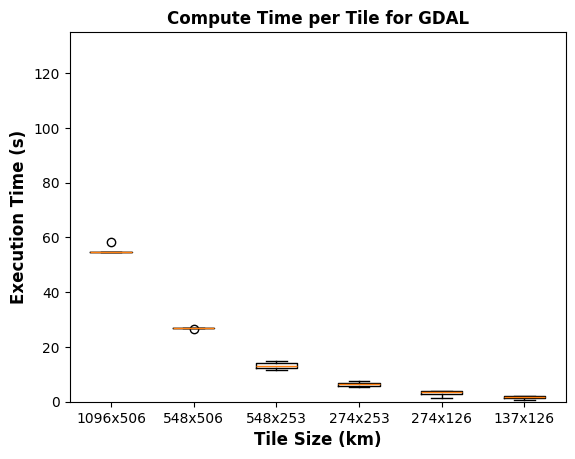

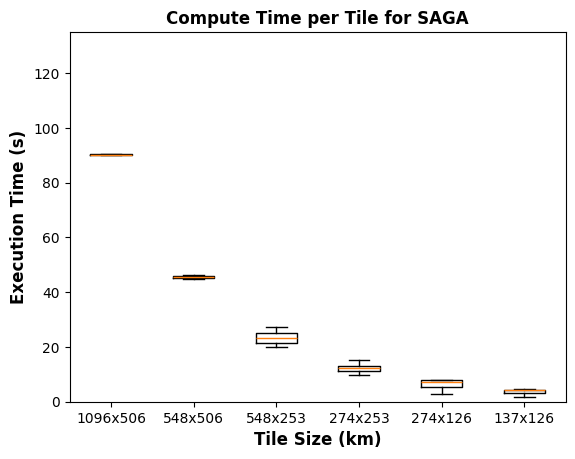

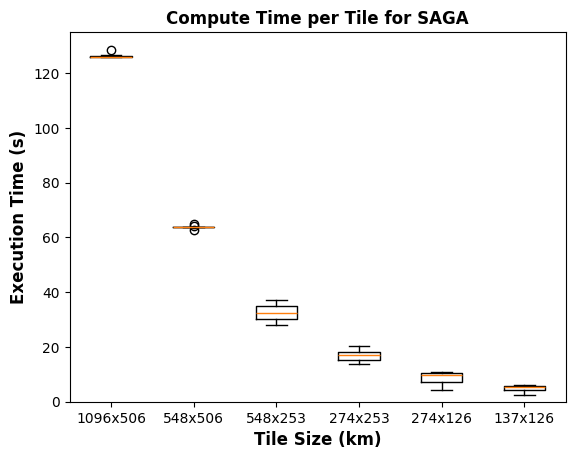

In [10]:
cm.plot_single_tile_results('results.csv', 'slope', 'GDAL', overhead=False, ylim=135)
cm.plot_single_tile_results('results.csv', 'slope', 'SAGA', overhead=False, ylim=135)
cm.plot_single_tile_results('results.csv', 'slope', 'SAGA', overhead=True, ylim=135)

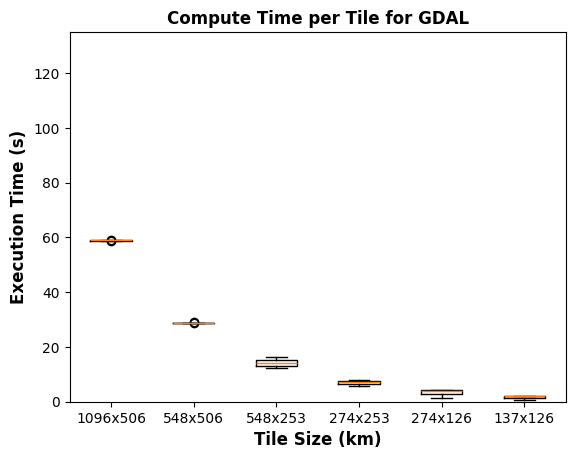

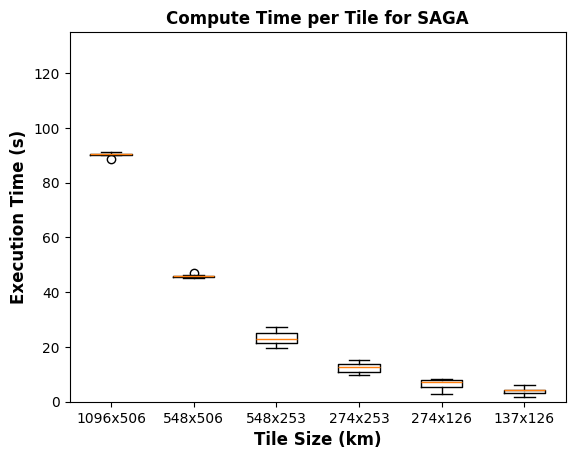

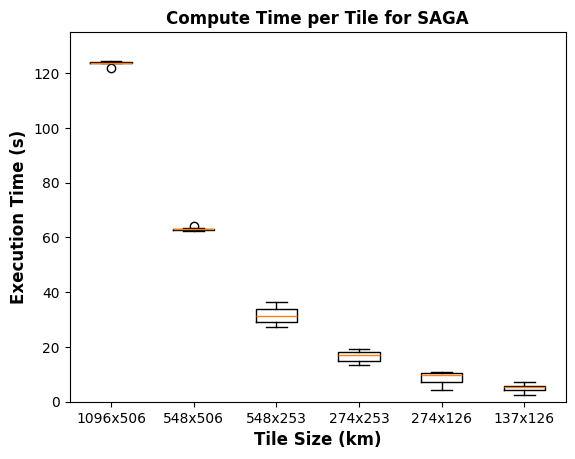

In [9]:
cm.plot_single_tile_results('results.csv', 'aspect', 'GDAL', overhead=False, ylim=135)
cm.plot_single_tile_results('results.csv', 'aspect', 'SAGA', overhead=False, ylim=135)
cm.plot_single_tile_results('results.csv', 'aspect', 'SAGA', overhead=True, ylim=135)

### End of Notebook